In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.data as skdata
from project.algorithms.simulation import dummy_object, ptychogram_shift, illumination_beam, ptychogram_pad
from project.algorithms.utils import circ_aperture, normalize, nrmse, ft, ift, corr, frashift
from project.algorithms.reconstruction import update_obj, update_probe, TransRefinement
import random

In [2]:
# Turn off for white background/jupyter notebook
background_dark = True
if background_dark:
    plt.style.use('dark_background')

In [3]:
"ground truth"
intensity = np.array(plt.imread('lena.tif'))
phase = skdata.camera()
obj = dummy_object(intensity=intensity, phase=phase, output_shape=(256, 256))
box_shape = (161, 161)   # the size of reconstruction box
r = 0.5
illumination = illumination_beam(box_shape, beam_radius=r)
illumination = normalize(illumination)

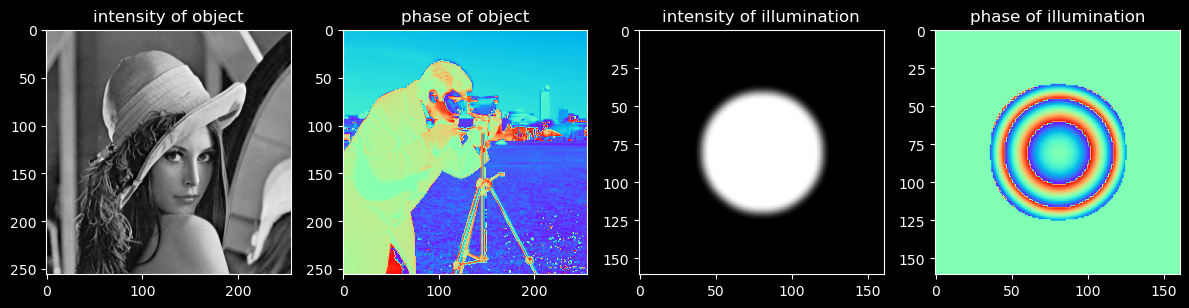

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(np.abs(obj), cmap='gray')
axes[0].set_title('intensity of object')
axes[1].imshow(np.angle(obj), cmap='rainbow')
axes[1].set_title('phase of object')
axes[2].imshow(np.abs(illumination), cmap='gray')
axes[2].set_title('intensity of illumination')
axes[3].imshow(np.angle(illumination), cmap='rainbow')
axes[3].set_title('phase of illumination')
plt.tight_layout()

In [5]:
"positions and ptychogram"
# positions = mesh((256, 256), 40, 0.9, 7, error=3)
positions = np.load('positions.npy')
patterns = []
for position in positions:
    pattern = ptychogram_shift(obj, illumination, position)
    # pattern = ptychogram_pad(obj, illumination, position)
    patterns.append(pattern)

In [6]:
"initial guess positions"
# guess_positions = np.array([[0, 0]]*len(positions)) + obj.shape[0]//2
guess_positions = np.load('ini_guess.npy')
ini_guess = guess_positions.copy()

In [7]:
"initial estimation and parameter"
# guess_probe = circ_aperture(box_shape, radius=0.5).astype('complex')
guess_probe = illumination
guess_obj = np.ones(obj.shape, dtype="complex")
# guess_positions = np.load('ini_guess.npy')
beta = [200] * 2
a, b = 1., 1.

In [8]:
"outputs"
loss, mpe = [], []
bx, by = [], []
sxlist, sylist = [], []

In [9]:
"reconstruction"
(K, L) = guess_probe.shape
(M, N) = guess_obj.shape
# obj_pad = np.pad(guess_obj, ((K // 2, K // 2), (L // 2, L // 2)))
position_errors = np.zeros((len(positions), 2, 2))
# guess_positions = positions.copy()

for n in range(100):
    loss_vals = []
    index = random.sample(range(0, len(positions)), len(positions))
    position_errors[:, :, 0] = position_errors[:, :, 1].copy()
    sy, sx = [], []
    for i in index:
    # for i in range(len(positions)):
        x = guess_positions[i][1]
        y = guess_positions[i][0]
        pattern = patterns[i]
        # obj_scanned = obj_pad[y:y + K, x:x + L]
        shift = -np.array([y - M//2, x - N//2]).astype('float')
        guess_obj = frashift(guess_obj, shift)
        obj_scanned = guess_obj[M//2 -K//2 : M//2+K//2+1, N//2-L//2 : N//2+L//2+1]

        "revise the wave function in diffraction plane"
        psi = obj_scanned * guess_probe
        Psi = ft(psi)
        phase_Psi = np.exp(1j * np.angle(Psi))
        Psi_corrected = np.sqrt(pattern) * phase_Psi
        psi_corrected = ift(Psi_corrected)

        "update the object and probe functions"
        diff_psi = psi_corrected - psi
        temp_obj = obj_scanned.copy()
        obj_scanned = update_obj(obj_scanned, guess_probe, diff_psi, learning_rate=a)
        # obj_pad[y:y + K, x:x + L] = obj_scanned
        guess_obj[M//2 -K//2 : M//2+K//2+1, N//2-L//2 : N//2+L//2+1] = obj_scanned
        guess_obj = frashift(guess_obj, -shift)
        guess_probe = update_probe(guess_probe, temp_obj, diff_psi, learning_rate=b)

        "NRMSE"
        loss_vals.append(nrmse(np.abs(Psi), pattern))

        "position correction"
        if n >= 3:
            syj, sxj = TransRefinement(obj_scanned, temp_obj, integer_skip=False)
            dy, dx = round(syj * beta[0]), round(sxj * beta[1])
            # dy, dx = syj * beta[0], sxj * beta[1]
            y += dy
            x += dx

            if y < 0:
                y = 1
            elif y >= guess_obj.shape[0]:
                y = guess_obj.shape[0] - 1
            if x < 0:
                x = 1
            elif x >= guess_obj.shape[1]:
                x = guess_obj.shape[1] - 1
            guess_positions[i] = np.array([y, x])
            sy.append(syj)
            sx.append(sxj)
            position_errors[i, :, 1] = np.array([syj, sxj])
    sylist.append(sy)
    sxlist.append(sx)

    "update beta"
    if n >= 5000000:
        ky = corr(position_errors[:, 0, 0], position_errors[:, 0, 1])
        kx = corr(position_errors[:, 1, 0], position_errors[:, 1, 1])

        if ky >= 0.4:
            beta[0] = int(beta[0] * 1.1)
        elif ky <= -0.4:
            beta[0] = int(beta[0] * 0.9)
        if kx >= 0.4:
            beta[1] = int(beta[1] * 1.1)
        elif kx <= -0.4:
            beta[1] = int(beta[1] * 0.9)
    bx.append(beta[1])
    by.append(beta[0])

    pe = guess_positions - np.array(positions)   # position errors
    pe = np.sum(np.sqrt(pe[:, 0]**2 + pe[:, 1]**2)) / 49
    mpe.append(pe)
    loss.append(loss_vals)

# guess_obj = obj_pad[K // 2:-K // 2 + 1, L // 2:-L // 2 + 1]

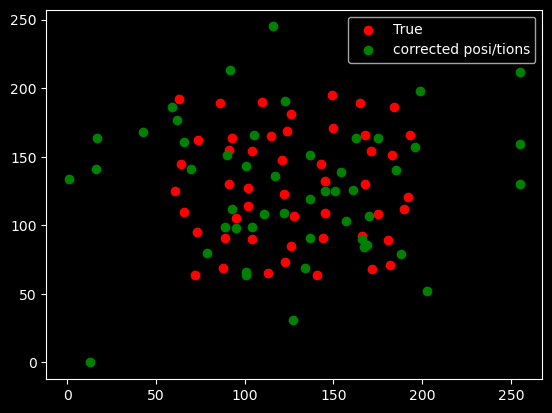

In [10]:
"plot position maps"
plt.figure()
plt.scatter(*np.transpose(positions), color='r', label='True')
# plt.scatter(*np.transpose(ini_guess), color='b', label='initial guess')
plt.scatter(*np.transpose(guess_positions), color='g', label='corrected posi/tions')
# plt.title(beta)
plt.legend()
plt.show()

In [11]:
del sylist[0:3]
sylist = np.array(sylist)

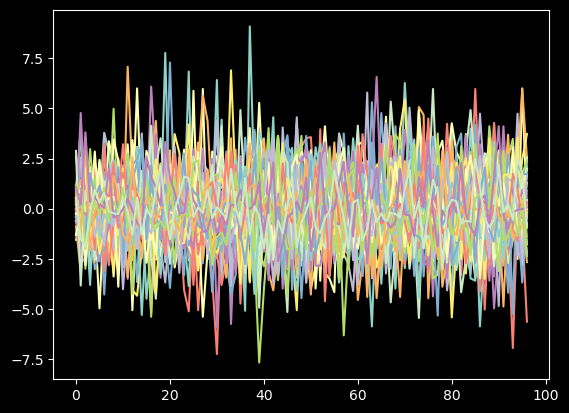

In [12]:
for i in range(sylist.shape[1]):
    plt.plot(sylist[:,i]*300)

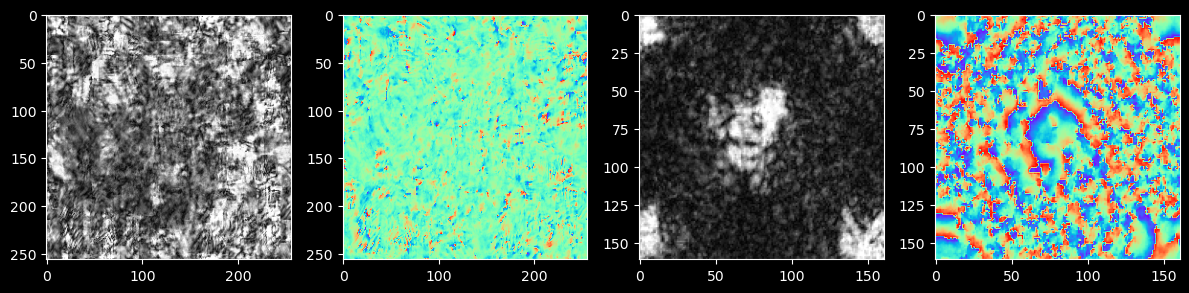

In [13]:
"imshow retrieved object and probe"
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(np.abs(guess_obj), cmap='gray')
axes[1].imshow(np.angle(guess_obj), cmap='rainbow')
axes[2].imshow(np.abs(guess_probe), cmap='gray')
axes[3].imshow(np.angle(guess_probe), cmap='rainbow')
plt.tight_layout()

In [14]:
print(mpe[-1])

47.77711914210103


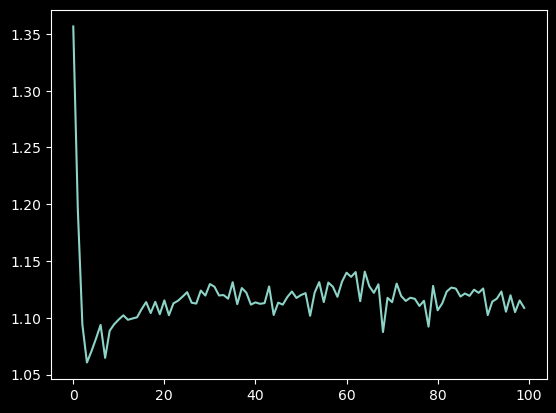

In [15]:
loss = np.array(loss)
# for i in range(200):
#     plt.plot(loss[i])
plt.plot(np.mean(loss,axis=1))
# plt.ylim(0.25, 0.5)

Text(0.5, 0, 'iteration')

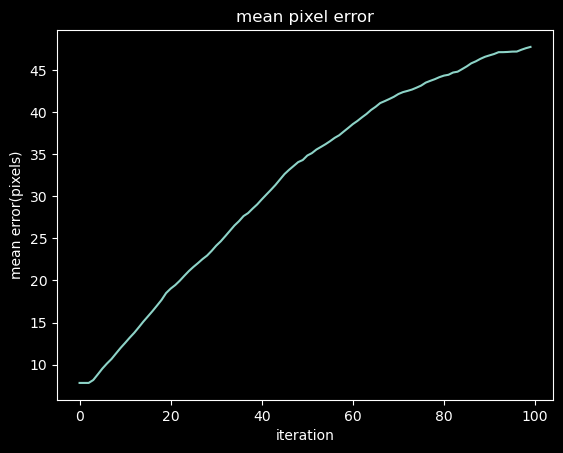

In [16]:
plt.plot(mpe)
plt.title('mean pixel error')
plt.ylabel('mean error(pixels)')
plt.xlabel('iteration')

In [ ]:
"data save"
c = True
if c:
    np.save('./result_store/positions%ic.npy'%bx[0], guess_positions)
    np.save('./result_store/obj%ic.npy'%bx[0], guess_obj)
    np.save('./result_store/probe%ic.npy'%bx[0], guess_probe)
    np.save('./result_store/nrmse%ic.npy'%bx[0], loss)
    np.save('./result_store/mpe%ic.npy'%bx[0], mpe)
    np.save('./result_store/bx%ic.npy'%bx[0], bx)
    np.save('./result_store/by%ic.npy'%bx[0], by)
else:
    np.save('./result_store/positions%i.npy'%bx[0], guess_positions)
    np.save('./result_store/obj%i.npy'%bx[0], guess_obj)
    np.save('./result_store/probe%i.npy'%bx[0], guess_probe)
    np.save('./result_store/nrmse%i.npy'%bx[0], loss)
    np.save('./result_store/mpe%i.npy'%bx[0], mpe)